The goal of this function is to identify subgroups of customers based on behavior patterns.  We identified groups based on magnitude of average daily use and on response to weather (as defined by k-shape clustering over sept-feb period)
Note: providing for archive purposes.  See FinalClusters.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
from timeit import default_timer as timer

In [6]:
# define data location
# location = '/Users/mithras/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'
location = '/Users/loki/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'

In [3]:
# Cumulative Distribution Function Plot
def cdf(x):
    """cumulative distribution function of a variable"""
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)
    
    # Go from 1/n to 1
    y = np.arange(1, n + 1, 1) / n
    
    return x, y

## Codebook analysis for full data ##

In [7]:
# if we're clustering first, we need to load in sufficient_ data to ensure data equivalency across IDs
if granularity == "daily":
    readdata = pd.read_pickle(location+'peco_daily.pkl.zip')
    ids = pd.read_pickle(location+'peco_daily_ids.pkl.zip')
elif granularity == "hourly":
    readdata = pd.read_pickle(location+'peco_hourly.pkl.zip')
    ids = pd.read_pickle(location+'peco_hourly_ids.pkl.zip')
else:
    print("Granularity selected was not 'daily' or 'hourly'")

In [7]:
# FOR MERGING
readdata['ID'] = readdata['DMETERNO'] 
readdata['ID'] = readdata['ID'].astype(str)
readdata.head()

,ID,Dt,Use,DACCOUNTID,DCUSTOMERID,DMETERNO,TARIFF,FUELTYPE,REVENUCODE,Weekday,Holiday
495153,606395738288,2017-10-01,1.00,68881639149832,3188526427696,606395738288,GH0,GAS,1.0,0,0
482563,608923719096,2017-10-01,0.00,68690879683500,19731696176432,608923719096,GH0,GAS,1.0,0,0
1063222,640944705832,2017-10-01,1.14,164788222898932,33149958808264,640944705832,GH0,GAS,1.0,0,0
482201,726789359116,2017-10-01,2.00,68689501197696,756418245856,726789359116,GH0,GAS,1.0,0,0
160918,640143121596,2017-10-01,4.12,20628346369984,24713480259220,640143121596,UHC,GAS,3.0,0,0


In [8]:
# aggregate to the daily level regardless of level of data read in
if granularity == 'daily':
    use = readdata[['ID','Use']].groupby('ID').mean().reset_index()
elif granularity == 'hourly':
    use = readdata[['ID','Dt','Use']]
    use['Dt'] = use['Dt'].dt.date
    use = use.groupby(['ID','Dt']).sum().reset_index()
    use = use.groupby('ID').mean().reset_index()

In [9]:
# it looks like we have 5 groups: 
# * minimal users (avg use <= 1.5)
# * light users (avg use > 1.5 & <= 3.5)
# * moderate users (avg use > 3.5 & <= 10)
# * high users (avg use > 10 & <= 150)
# * huge users (avg use > 150)
use['UseGroup'] = None
use.loc[ use.Use <= 1.5, 'UseGroup'] = 0
use.loc[ (use.Use > 1.5) & (use.Use <= 3.5), 'UseGroup'] = 1
use.loc[ (use.Use > 3.5) & (use.Use <= 10), 'UseGroup'] = 2
#use.loc[ (use.Use > 10), 'UseGroup'] = 3
use.loc[ (use.Use > 10) & (use.Use <= 150), 'UseGroup'] = 3
use.loc[ (use.Use > 150), 'UseGroup'] = 4
use.head()

,ID,Use,UseGroup
0,1067083776672,91.860635,3
1,1067084436476,15.424641,3
2,1067085406776,26.022529,3
3,1067088705796,39.440221,3
4,1067089210352,18.969613,3


In [10]:
# look at whether there's a difference in use between cold months and warm months (i.e., is there gas heat?)
readdata['coldmonths'] = pd.get_dummies((readdata['Dt'].dt.month <= 2) | (readdata['Dt'].dt.month >= 11))[True]
readdata['warmmonths'] = pd.get_dummies((readdata['Dt'].dt.month >= 6) & (readdata['Dt'].dt.month <= 9))[True]

cold = (readdata[readdata['coldmonths']==1][['ID','Use']]#### are there distinct groups based on magnitude of use? ####
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'colduse'}))
warm = (readdata[readdata['warmmonths']==1][['ID','Use']]
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'warmuse'}))
total = (readdata[(readdata['coldmonths']==1) | (readdata['warmmonths']==1)][['ID','Use']]
         .groupby('ID').sum().reset_index()
         .rename(columns={'Use':'totaluse'}))

gasheat = cold.merge(warm, how='inner', on='ID').merge(total, how='inner', on='ID')
gasheat['pctcold'] = gasheat['colduse']/gasheat['totaluse']

del (cold,warm,total)
readdata = readdata.drop(columns=['coldmonths','warmmonths'])

# 3 proportion winter groups: 
# * those using <59% gas in the winter, 
# * those using 59-80% gas in winter, 
# * those using >80% gas in winter
gasheat['ColdGroup'] = None
gasheat.loc[ gasheat.pctcold < .68, 'ColdGroup'] = 0
gasheat.loc[ (gasheat.pctcold >= .68) & (gasheat.pctcold < .8), 'ColdGroup'] = 1
gasheat.loc[ gasheat.pctcold >= .8, 'ColdGroup'] = 2
gasheat.head()

,ID,colduse,warmuse,totaluse,pctcold,ColdGroup
0,1067083776672,15309.92,6650.71,21960.63,0.697153,1
1,1067084436476,3586.44,91.20,3677.64,0.975201,2
2,1067085406776,4893.53,1.03,4894.56,0.999790,2
3,1067088705796,8503.26,1394.22,9897.48,0.859134,2
4,1067089210352,4960.00,0.00,4960.00,1.000000,2


In [11]:
# look at whether there's a difference in use between weekdays and weekends/holidays
weekday = (readdata[(readdata['Weekday']==1) & (readdata['Holiday']==0)][['ID','Use']]
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'wdayuse'}))
weekend = (readdata[(readdata['Weekday']==0) | (readdata['Holiday']==1)][['ID','Use']]
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'wenduse'}))
total = (readdata[['ID','Use']]
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'totaluse'}))

dayuse = (weekday.merge(weekend, how='inner', on='ID').merge(total, how='inner', on='ID'))
dayuse['pctwday'] = dayuse['wdayuse'] / dayuse['totaluse']
dayuse['pctwend'] = dayuse['wenduse'] / dayuse['totaluse']

del (weekday,weekend,total)

# fairly tight distribution with no clear breaks; split at median
# Note: expect this to be weighted toward weekdays (5/7=.714...)
dayuse['DayGroup'] = None
dayuse.loc[ dayuse.pctwend < dayuse['pctwday'].median(), 'DayGroup'] = 0
dayuse.loc[ dayuse.pctwend > dayuse['pctwday'].median(), 'DayGroup'] = 1

In [187]:
# # look at timegroup?
# if granularity == 'hourly':
#     timeuse['TimeGroup']=None
#     #...

In [188]:
gasheat.head()

,ID,colduse,warmuse,totaluse,pctcold,ColdGroup
0,1067083776672,15309.92,6650.71,21960.63,0.697153,1
1,1067084436476,3586.44,91.20,3677.64,0.975201,2
2,1067085406776,4893.53,1.03,4894.56,0.999790,2
3,1067088705796,8503.26,1394.22,9897.48,0.859134,2
4,1067089210352,4960.00,0.00,4960.00,1.000000,2


In [12]:
# make codebook
codebook_full = (readdata[['ID','TARIFF','REVENUCODE']].drop_duplicates()
            .merge(use[['ID','Use','UseGroup']], how='inner', on='ID')
            .merge(gasheat[['ID','ColdGroup']], how='inner', on='ID')
            .merge(dayuse[['ID','DayGroup']], how='inner', on='ID'))

if granularity == 'hourly':
    codebook_full = codebook_full.merge(timeuse[['ID','TimeGroup']], how='inner', on='ID')
    del timeuse

# del (use,gasheat,dayuse)

In [13]:
codebook_full['Cluster'] = None
codebook_full.loc[ (codebook_full.UseGroup == 0) & (codebook_full.ColdGroup == 0), 'Cluster'] = 'N_L' # low users, less in winter
codebook_full.loc[ (codebook_full.UseGroup == 1) & (codebook_full.ColdGroup == 0), 'Cluster'] = 'L_L' # light users, less in winter
codebook_full.loc[ (codebook_full.UseGroup == 2) & (codebook_full.ColdGroup == 0), 'Cluster'] = 'M_L' # moderate users, less in winter
codebook_full.loc[ (codebook_full.UseGroup == 3) & (codebook_full.ColdGroup == 0), 'Cluster'] = 'H_L' # heavy users, less in winter
codebook_full.loc[ (codebook_full.UseGroup == 4) & (codebook_full.ColdGroup == 0), 'Cluster'] = 'V_L' # very hvy users, less in winter
codebook_full.loc[ (codebook_full.UseGroup == 0) & (codebook_full.ColdGroup == 1), 'Cluster'] = 'N_M' # low users, moderate in winter
codebook_full.loc[ (codebook_full.UseGroup == 1) & (codebook_full.ColdGroup == 1), 'Cluster'] = 'L_M' # light users, moderate in winter
codebook_full.loc[ (codebook_full.UseGroup == 2) & (codebook_full.ColdGroup == 1), 'Cluster'] = 'M_M' # moderate users, moderate in winter
codebook_full.loc[ (codebook_full.UseGroup == 3) & (codebook_full.ColdGroup == 1), 'Cluster'] = 'H_M' # heavy users, moderate in winter
codebook_full.loc[ (codebook_full.UseGroup == 4) & (codebook_full.ColdGroup == 1), 'Cluster'] = 'V_M' # very hvy users, mod in winter
codebook_full.loc[ (codebook_full.UseGroup == 0) & (codebook_full.ColdGroup == 2), 'Cluster'] = 'N_H' # low users, heavy in winter
codebook_full.loc[ (codebook_full.UseGroup == 1) & (codebook_full.ColdGroup == 2), 'Cluster'] = 'L_H' # light users, heavy in winter
codebook_full.loc[ (codebook_full.UseGroup == 2) & (codebook_full.ColdGroup == 2), 'Cluster'] = 'M_H' # moderate users, heavy in winter
codebook_full.loc[ (codebook_full.UseGroup == 3) & (codebook_full.ColdGroup == 2), 'Cluster'] = 'H_H' # heavy users, heavy in winter
codebook_full.loc[ (codebook_full.UseGroup == 4) & (codebook_full.ColdGroup == 2), 'Cluster'] = 'V_H' # very hvy users, hvy in winter
codebook_full.head()

,ID,TARIFF,REVENUCODE,Use,UseGroup,ColdGroup,DayGroup,Cluster
0,606395738288,GH0,1.0,1.356354,0,1,0,N_M
1,608923719096,GH0,1.0,0.582873,0,2,0,N_H
2,640944705832,GH0,1.0,2.998011,1,2,0,L_H
3,726789359116,GH0,1.0,3.856354,2,2,0,M_H
4,640143121596,UHC,3.0,5.585331,2,0,0,M_L


In [14]:
# # save! FOR MERGE
codebook_full.to_pickle(location+'codebook_full_dmeterno_'+granularity+'.pkl.zip')

## Kshape Cluster ##
Note: below code is sample code so kshape is present in this script.  Actual kshape results were imported in above

In [235]:
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KShape
from tslearn.clustering import TimeSeriesKMeans
# from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler

import numpy
import matplotlib.pyplot as plt
%matplotlib inline

In [145]:
# if we're clustering first, we need to load in sufficient_ data to ensure data equivalency across IDs
if granularity == "daily":
    readdata = pd.read_pickle(location+'peco_daily.pkl.zip')
    ids = pd.read_pickle(location+'peco_daily_ids.pkl.zip')
elif granularity == "hourly":
    readdata = pd.read_pickle(location+'peco_hourly.pkl.zip')
    ids = pd.read_pickle(location+'peco_hourly_ids.pkl.zip')
else:
    print("Granularity selected was not 'daily' or 'hourly'")

codebook = pd.read_pickle(location+'codebook_full_dmeterno_daily'+'.pkl.zip')

In [146]:
# FOR MERGING
readdata['ID'] = readdata['DMETERNO'] 
readdata['ID'] = readdata['ID'].astype(str)
readdata.head()

,ID,Dt,Use,DACCOUNTID,DCUSTOMERID,DMETERNO,TARIFF,FUELTYPE,REVENUCODE,Weekday,Holiday
495153,606395738288,2017-10-01,1.00,68881639149832,3188526427696,606395738288,GH0,GAS,1.0,0,0
482563,608923719096,2017-10-01,0.00,68690879683500,19731696176432,608923719096,GH0,GAS,1.0,0,0
1063222,640944705832,2017-10-01,1.14,164788222898932,33149958808264,640944705832,GH0,GAS,1.0,0,0
482201,726789359116,2017-10-01,2.00,68689501197696,756418245856,726789359116,GH0,GAS,1.0,0,0
160918,640143121596,2017-10-01,4.12,20628346369984,24713480259220,640143121596,UHC,GAS,3.0,0,0


In [147]:
# FOR MERGING
codebook['ID'] = codebook['ID'].astype(str)
codebook.head()

,ID,TARIFF,REVENUCODE,Use,UseGroup,ColdGroup,DayGroup,Cluster
0,606395738288,GH0,1.0,1.356354,0,1,0,N_M
1,608923719096,GH0,1.0,0.582873,0,2,0,N_H
2,640944705832,GH0,1.0,2.998011,1,2,0,L_H
3,726789359116,GH0,1.0,3.856354,2,2,0,M_H
4,640143121596,UHC,3.0,5.585331,2,0,0,M_L


In [148]:
# merge
data = readdata[['ID','Dt','Use']]
data = data.merge(codebook[['ID','UseGroup']], how='inner', on='ID')
data.head()

,ID,Dt,Use,UseGroup
0,606395738288,2017-10-01,1.0,0
1,606395738288,2017-10-02,1.0,0
2,606395738288,2017-10-03,0.0,0
3,606395738288,2017-10-04,1.0,0
4,606395738288,2017-10-05,1.0,0


In [219]:
# create data per UseGroup for kshape
# filling with 0s to allow for normalization
data_min = data[data['UseGroup']==0].pivot_table(index='ID', columns='Dt', values='Use', fill_value=0)
data_low = data[data['UseGroup']==1].pivot_table(index='ID', columns='Dt', values='Use', fill_value=0)
data_med = data[data['UseGroup']==2].pivot_table(index='ID', columns='Dt', values='Use', fill_value=0)
data_hi = data[data['UseGroup']==3].pivot_table(index='ID', columns='Dt', values='Use', fill_value=0)
data_vhi = data[data['UseGroup']==4].pivot_table(index='ID', columns='Dt', values='Use', fill_value=0)
#del(data)

In [221]:
# create time-series data for each use group
ts0 = to_time_series_dataset(np.array(data_min))
ts1 = to_time_series_dataset(np.array(data_low))
ts2 = to_time_series_dataset(np.array(data_med))
ts3 = to_time_series_dataset(np.array(data_hi))
ts4 = to_time_series_dataset(np.array(data_vhi))

#### Usegroup 0 ####

In [251]:
# k-shape
# set params for kshape or kmeans-dtw
dat = ts0 # set usegroup
k=3 # set k

seed = 0
np.random.seed(seed)
#To calculate cross-correlation, you need to normalize.
#TimeSeriesScalerMeanVariance is the class that normalizes the data.
stack_data = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0).fit_transform(dat)

#Instantiation of the KShape class 
ks = KShape(n_clusters=k, n_init=10, verbose=True, random_state=seed)
y_pred = ks.fit_predict(stack_data)

Init 1
0.236 --> 0.195 --> 0.190 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 0.188 --> 
Init 2
0.232 --> 0.205 --> 0.200 --> 0.196 --> 0.194 --> 0.192 --> 0.191 --> 0.189 --> 0.187 --> 0.187 --> 0.187 --> 0.187 --> 
Init 3
0.232 --> 0.212 --> 0.207 --> 0.203 --> 0.200 --> 0.197 --> 0.196 --> 0.195 --> 0.195 --> 
Init 4
0.267 --> 0.219 --> 0.210 --> 0.206 --> 0.203 --> 0.200 --> 0.198 --> 0.196 --> 0.194 --> 0.193 --> 0.192 --> 0.192 --> 0.191 --> 0.191 --> 0.191 --> 0.190 --> 0.190 --> 0.190 --> 0.190 --> 0.190 --> 0.189 --> 0.189 --> 0.189 --> 0.189 --> 0.189 --> 0.189 --> 
Init 5
0.229 --> 0.197 --> 0.188 --> 0.185 --> 0.185 --> 0.185 --> 0.185 --> 
Init 6
0.235 --> 0.205 --> 0.200 --> 0.198 --> 0.197 --> 0.197 --> 0.196 --> 0.196 --> 0.195 --> 0.194 --> 0.193 --> 0.191 --> 0.189 --> 0.187 --> 0.187 --> 0.186 --> 0.186 --> 0.186 --> 0.186 --> 0.185 --> 0.185 --> 0.185 --> 0.185 --> 0.185 --> 0.185 --> 0.185 --> 0.184 --> 0.184 --> 0.184 --> 0.184 --> 0.184 --> 0.184 --> 0.1

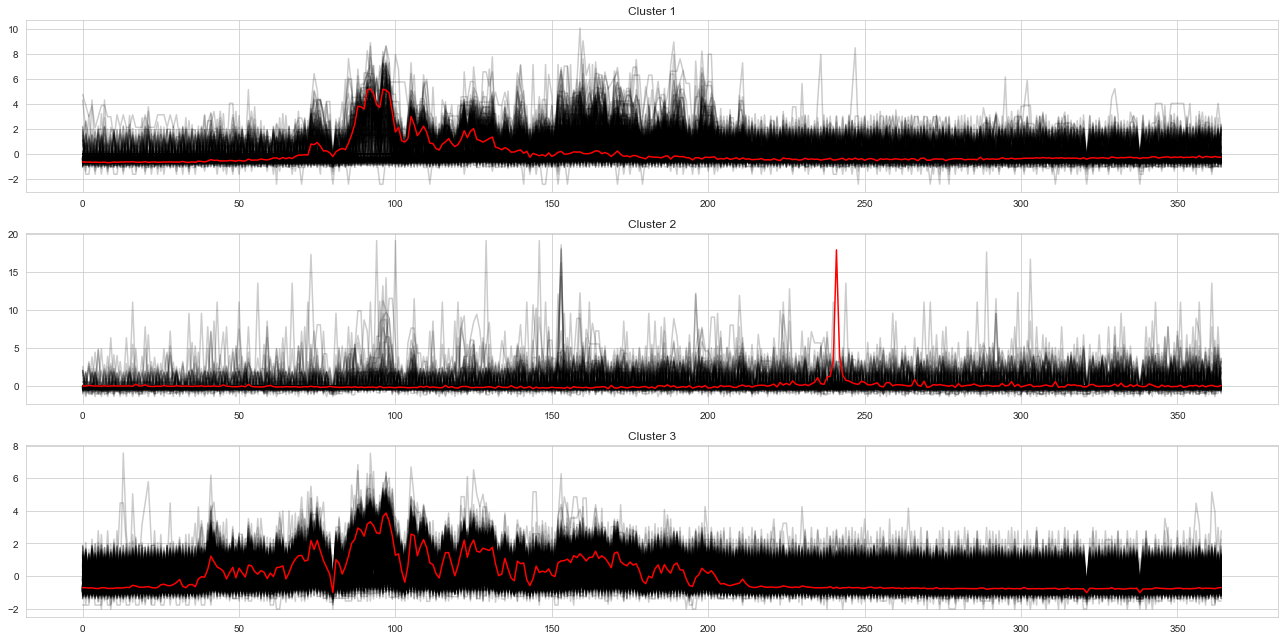

In [252]:
#Clustering and visualization 

f, ax = plt.subplots(figsize=(18,9))
sns.set_style('whitegrid')

for yi in range(k):
    plt.subplot(k, 1, 1 + yi)
    for xx in stack_data[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    ax.xaxis.set_ticks(np.arange(0, 365, step=30))
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

In [245]:
# save cluster identities
clust0 = y_pred

In [236]:
# Soft-DTW-k-means
seed = 0
np.random.seed(seed)

stack_data = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0).fit_transform(dat)

sdtw_km = TimeSeriesKMeans(n_clusters=k, metric="softdtw", metric_params={"gamma_sdtw": .01},
                           verbose=True, random_state=seed)
y_pred = sdtw_km.fit_predict(stack_data)


19736.736 --> 6475.407 --> 6324.032 --> 6313.374 --> 6304.776 --> 6303.472 --> 6301.227 --> 6298.460 --> 6296.925 --> 6295.179 --> 6296.371 --> 6291.881 --> 6289.313 --> 6285.471 --> 6286.279 --> 6284.827 --> 6285.490 --> 6284.833 --> 6284.700 --> 6283.672 --> 6283.178 --> 6281.495 --> 6281.475 --> 6279.720 --> 6279.889 --> 6279.103 --> 6279.198 --> 6278.490 --> 6278.362 --> 6277.936 --> 6278.134 --> 6278.004 --> 6278.120 --> 6277.628 --> 6277.727 --> 6276.839 --> 6276.944 --> 6275.211 --> 6275.258 --> 6273.563 --> 6274.216 --> 6272.784 --> 6273.169 --> 6271.407 --> 6272.069 --> 6270.675 --> 6271.274 --> 6269.356 --> 6270.003 --> 6268.961 --> 


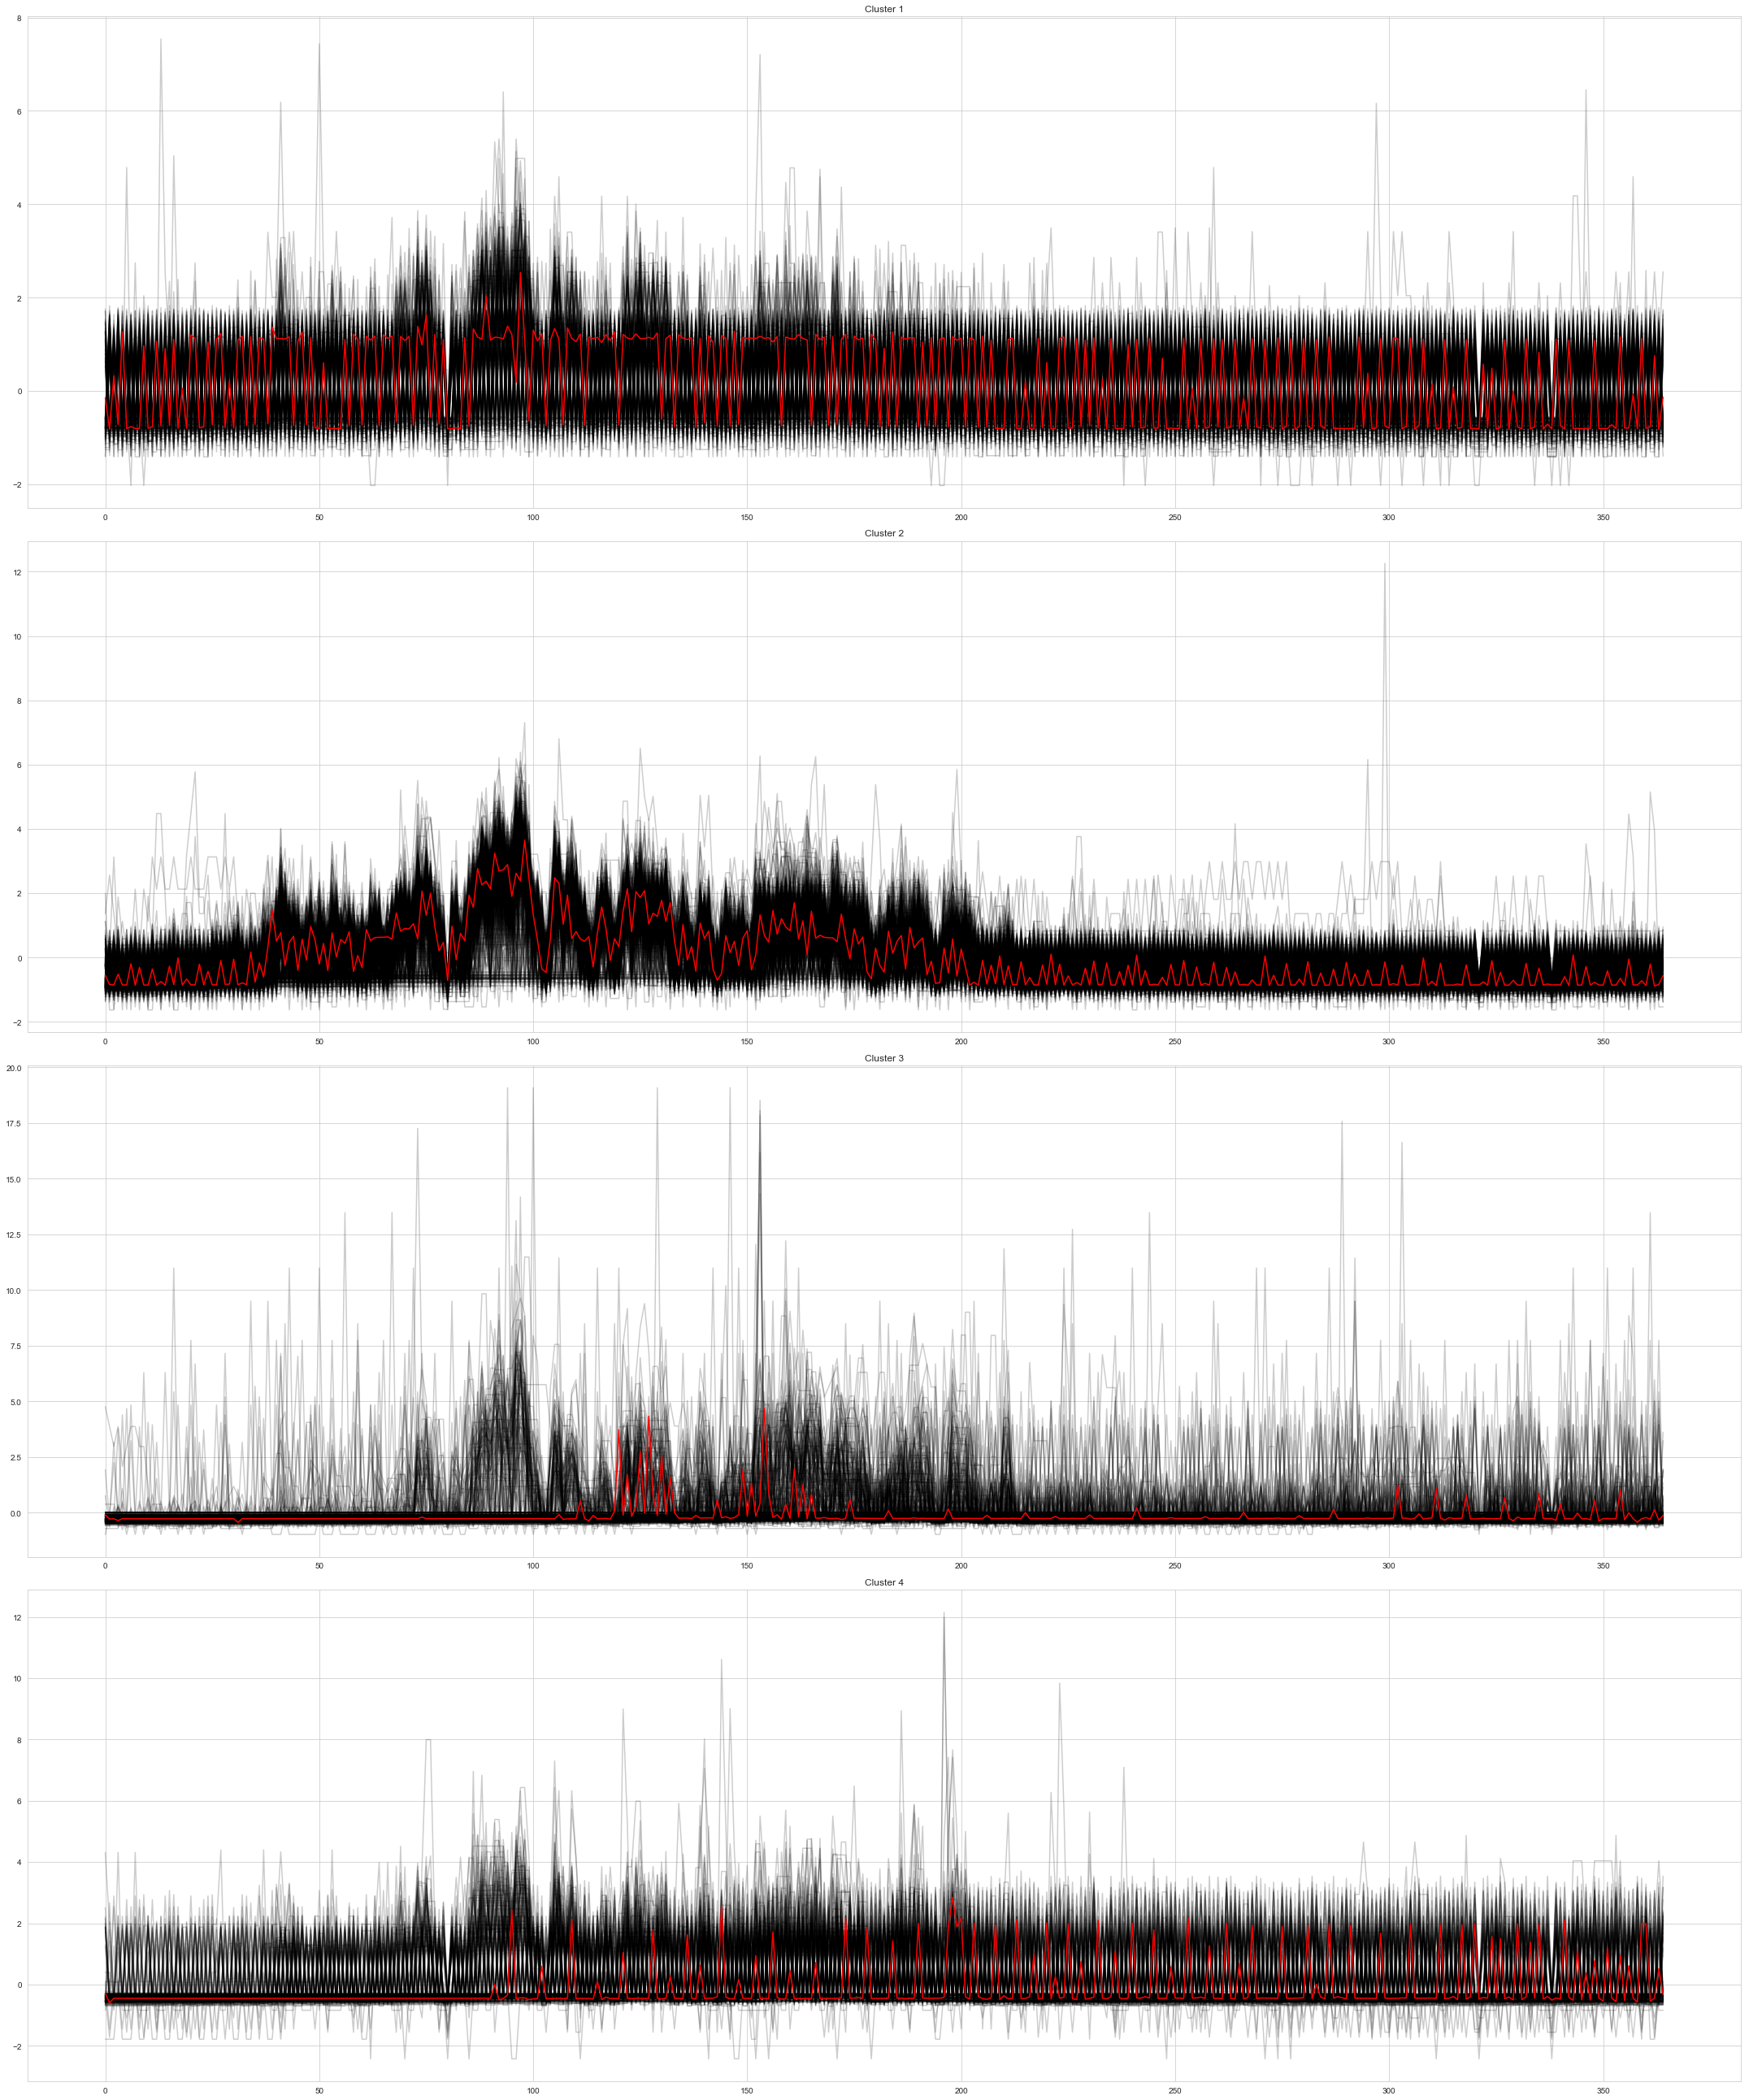

In [237]:
#Clustering and visualization
plt.figure(figsize=(30,36))
for yi in range(k):
    plt.subplot(k, 1, 1 + yi)
    for xx in stack_data[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

Note: below code is depricated due to two reasons:
1) no longer using 'sufficient' dataset
2) no longer using % use in winter, instead using kshape clusters to identify response to weather.

## Behavioral Analysis ##

In [37]:
# read data from pickle
start = timer()

# what data granularity?
granularity = "daily"

# if we're clustering first, we need to load in sufficient_ data to ensure data equivalency across IDs
if granularity == "daily":
    readdata = pd.read_pickle(location+'peco_sufficient_daily.pkl.zip')
    weather = pd.read_pickle(location+'daily_weather.pkl.zip')
    ids = pd.read_pickle(location+'peco_sufficient_daily_ids.pkl.zip')
elif granularity == "hourly":
    readdata = pd.read_pickle(location+'peco_sufficient_hourly.pkl.zip')
    weather = pd.read_pickle(location+'hourly_weather.pkl.zip')
    ids = pd.read_pickle(location+'peco_sufficient_hourly_ids.pkl.zip')
else:
    print("Granularity selected was not 'daily' or 'hourly'")

end = timer()
print((end - start)/60) # Time in minutes (~7 min for hourly data)

0.00969994346666662


In [38]:
readdata.head()

,ID,Dt,Use,DACCOUNTID,DCUSTOMERID,DMETERNO,TARIFF,FUELTYPE,REVENUCODE,Weekday,Holiday
634064,"(92567555369200, 732213258492)",2017-10-12,1.0,92567555369200,29381522572072,732213258492,GH0,GAS,1.0,1,0
997476,"(153032728174616, 796095404148)",2017-10-12,0.0,153032728174616,518685586224,796095404148,GHC,GAS,3.0,1,0
996753,"(152994924937308, 724945750304)",2017-10-12,5.7,152994924937308,3403523328224,724945750304,UHC,GAS,3.0,1,0
1480056,"(238775655555924, 4967981836972)",2017-10-12,0.0,238775655555924,3153998418632,4967981836972,UHC,GAS,3.0,1,0
1028268,"(163414110819212, 606793638912)",2017-10-12,1.0,163414110819212,1704916575156,606793638912,UGH,GAS,1.0,1,0


#### are there distinct groups based on magnitude of use? ####

In [40]:
# aggregate to the daily level regardless of level of data read in
if granularity == 'daily':
    use = readdata[['ID','Use']].groupby('ID').mean().reset_index()
elif granularity == 'hourly':
    use = readdata[['ID','Dt','Use']]
    use['Dt'] = use['Dt'].dt.date
    use = use.groupby(['ID','Dt']).sum().reset_index()
    use = use.groupby('ID').mean().reset_index()
    
use.head()

,ID,Use
0,"(665128346596, 4464578359312)",0.431925
1,"(819252079392, 609154378812)",0.403602
2,"(819288717920, 4465122076620)",0.895714
3,"(819880484484, 4465122193056)",0.948820
4,"(1284453836940, 4464330738752)",0.739938


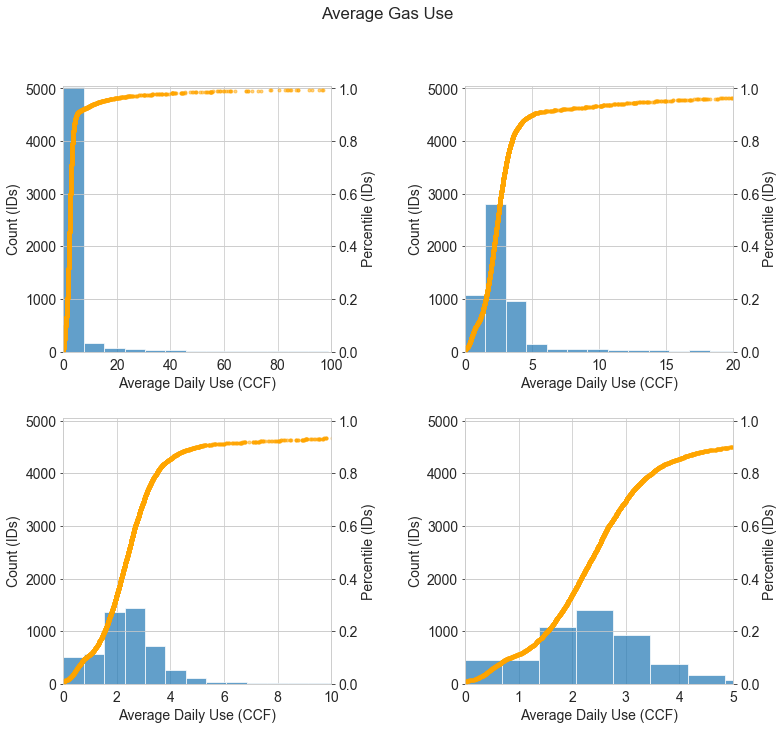

In [41]:
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,11))
sns.set_style('whitegrid')
fig.suptitle('Average Gas Use')
fig.subplots_adjust(hspace=0.25, wspace=0.5)

x, y = cdf(use['Use'])

# axs[0,0].hist(use['Use'], 100, alpha=.7)
# axs[0,0].set_xlim(0,1000)
# axs[0,0].set_ylim(0,5050)
# layer1 = axs[0,0].twinx()
# layer1.plot(x, y, '.', color="orange", alpha=.5)
# layer1.set_ylim(0,1.01)
# axs[0,0].set_xlabel("Average Daily Use (CCF)"); axs[0,0].set_ylabel("Count (IDs)"); layer1.set_ylabel("Percentile (IDs)"); 

axs[0,0].hist(use['Use'], 500, alpha=.7)
axs[0,0].set_xlim(0,100)
axs[0,0].set_ylim(0,5050)
layer2 = axs[0,0].twinx()
layer2.plot(x, y, '.', color="orange", alpha=.5)
layer2.set_ylim(0,1.01)
axs[0,0].set_xlabel("Average Daily Use (CCF)"); axs[0,0].set_ylabel("Count (IDs)"); layer2.set_ylabel("Percentile (IDs)"); 

# axs[0,2].hist(use['Use'], 1000, alpha=.7)
# axs[0,2].set_xlim(0,50); axs[0,2].xaxis.set_ticks(np.arange(0, 60, step=10))
# axs[0,2].set_ylim(0,5050)
# layer3 = axs[0,2].twinx()
# layer3.plot(x, y, '.', color="orange", alpha=.5)
# layer3.set_ylim(0,1.01)
# axs[0,2].set_xlabel("Average Daily Use (CCF)"); axs[0,2].set_ylabel("Count (IDs)"); layer3.set_ylabel("Percentile (IDs)"); 

# second row
axs[0,1].hist(use['Use'], 2500, alpha=.7)
axs[0,1].set_xlim(0,20)
axs[0,1].set_ylim(0,5050)
layer4 = axs[0,1].twinx()
layer4.plot(x, y, '.', color="orange", alpha=.5)
layer4.set_ylim(0,1.01)
axs[0,1].set_xlabel("Average Daily Use (CCF)"); axs[0,1].set_ylabel("Count (IDs)"); layer4.set_ylabel("Percentile (IDs)"); 

axs[1,0].hist(use['Use'], 5000, alpha=.7)
axs[1,0].set_xlim(0,10)
axs[1,0].set_ylim(0,5050)
layer5 = axs[1,0].twinx()
layer5.plot(x, y, '.', color="orange", alpha=.5)
layer5.set_ylim(0,1.01)
axs[1,0].set_xlabel("Average Daily Use (CCF)"); axs[1,0].set_ylabel("Count (IDs)"); layer5.set_ylabel("Percentile (IDs)"); 

axs[1,1].hist(use['Use'], 5500, alpha=.7)
axs[1,1].set_xlim(0,5); axs[1,1].xaxis.set_ticks(np.arange(0, 6, step=1))
axs[1,1].set_ylim(0,5050)
layer6 = axs[1,1].twinx()
layer6.plot(x, y, '.', color="orange", alpha=.5)
layer6.set_ylim(0,1.01)
axs[1,1].set_xlabel("Average Daily Use (CCF)"); axs[1,1].set_ylabel("Count (IDs)"); layer6.set_ylabel("Percentile (IDs)"); 

# save
fig.savefig(location+'Avg_gas_use.png')

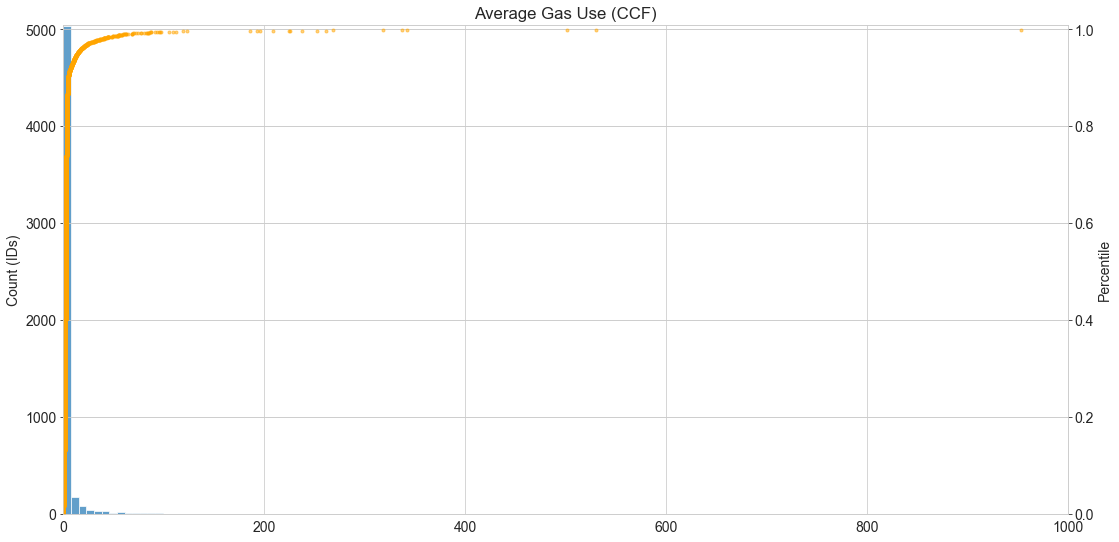

In [42]:
# plot 
plt.rcParams.update({'font.size': 14})

f, ax = plt.subplots(figsize=(18,9))
sns.set_style('whitegrid')

x, y = cdf(use['Use'])


ax.hist(use['Use'], bins=500, alpha=.7)
ax.set_xlim(0,1000)
ax.set_ylim(0,5050)
layer = ax.twinx()
layer.plot(x, y, '.', color="orange", alpha=.5)

plt.title('Average Gas Use (CCF)'); 
plt.xlabel('Average Gas Use (CCF)'); ax.set_ylabel('Count (IDs)'); layer.set_ylabel('Percentile'); 

# save
f.savefig(location+'Avg_gas_use_wide.png')

In [43]:
# it looks like we have 5 groups: 
# * minimal users (avg use <= 1.5)
# * light users (avg use > 1.5 & <= 3.5)
# * moderate users (avg use > 3.5 & <= 10)
# * high users (avg use > 10 & <= 150)
# * huge users (avg use > 150)
use['UseGroup'] = None
use.loc[ use.Use <= 1.5, 'UseGroup'] = 0
use.loc[ (use.Use > 1.5) & (use.Use <= 3.5), 'UseGroup'] = 1
use.loc[ (use.Use > 3.5) & (use.Use <= 10), 'UseGroup'] = 2
#use.loc[ (use.Use > 10), 'UseGroup'] = 3
use.loc[ (use.Use > 10) & (use.Use <= 150), 'UseGroup'] = 3
use.loc[ (use.Use > 150), 'UseGroup'] = 4
use.head()

,ID,Use,UseGroup
0,"(665128346596, 4464578359312)",0.431925,0
1,"(819252079392, 609154378812)",0.403602,0
2,"(819288717920, 4465122076620)",0.895714,0
3,"(819880484484, 4465122193056)",0.948820,0
4,"(1284453836940, 4464330738752)",0.739938,0


#### Is there a difference in use between cold months and warm months (i.e., is there gas heat?) ####

In [44]:
# look at whether there's a difference in use between cold months and warm months (i.e., is there gas heat?)
readdata['coldmonths'] = pd.get_dummies((readdata['Dt'].dt.month <= 2) | (readdata['Dt'].dt.month >= 11))[True]
readdata['warmmonths'] = pd.get_dummies((readdata['Dt'].dt.month >= 6) & (readdata['Dt'].dt.month <= 9))[True]

cold = (readdata[readdata['coldmonths']==1][['ID','Use']]#### are there distinct groups based on magnitude of use? ####
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'colduse'}))
warm = (readdata[readdata['warmmonths']==1][['ID','Use']]
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'warmuse'}))
total = (readdata[(readdata['coldmonths']==1) | (readdata['warmmonths']==1)][['ID','Use']]
         .groupby('ID').sum().reset_index()
         .rename(columns={'Use':'totaluse'}))

gasheat = cold.merge(warm, how='inner', on='ID').merge(total, how='inner', on='ID')
gasheat['pctcold'] = gasheat['colduse']/gasheat['totaluse']

del (cold,warm,total)
readdata = readdata.drop(columns=['coldmonths','warmmonths'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


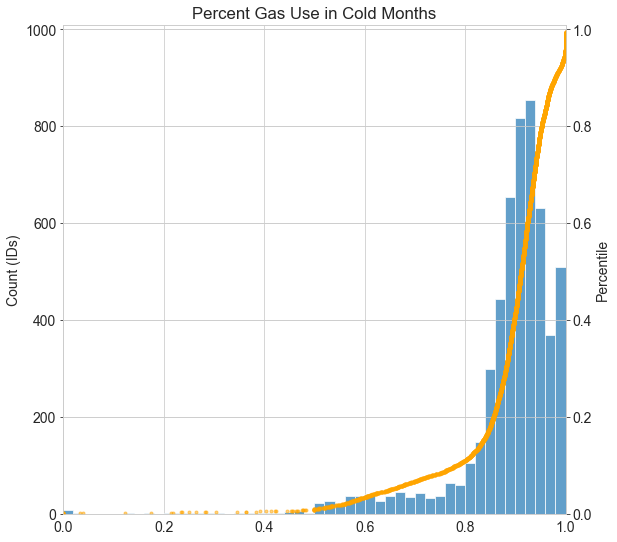

In [45]:
# plot 
plt.rcParams.update({'font.size': 14})

f, ax = plt.subplots(figsize=(9,9))
sns.set_style('whitegrid')

x, y = cdf(gasheat['pctcold'])
ax.hist(gasheat['pctcold'], bins=50, alpha=.7)
ax.set_xlim(0,1)
ax.set_ylim(0,1010)
layer = ax.twinx()
layer.plot(x, y, '.', color="orange", alpha=.5)
layer.set_ylim(0,1.01)
plt.title('Percent Gas Use in Cold Months'); 
plt.xlabel('Pct Use in Cold Months'); ax.set_ylabel('Count (IDs)'); layer.set_ylabel('Percentile'); 

# save
f.savefig(location+'cold_gas_use.png')

In [46]:
# it looks like we have 3 groups: 
# * those using <59% gas in the winter, 
# * those using 59-80% gas in winter, 
# * those using >80% gas in winter
gasheat['ColdGroup'] = None
gasheat.loc[ gasheat.pctcold < .68, 'ColdGroup'] = 0
gasheat.loc[ (gasheat.pctcold >= .68) & (gasheat.pctcold < .8), 'ColdGroup'] = 1
gasheat.loc[ gasheat.pctcold >= .8, 'ColdGroup'] = 2
gasheat.head()

,ID,colduse,warmuse,totaluse,pctcold,ColdGroup
0,"(665128346596, 4464578359312)",68.40,33.06,101.46,0.674157,0
1,"(819252079392, 609154378812)",60.42,28.50,88.92,0.679487,0
2,"(819288717920, 4465122076620)",157.32,42.18,199.50,0.788571,1
3,"(819880484484, 4465122193056)",87.78,106.02,193.80,0.452941,0
4,"(1284453836940, 4464330738752)",87.78,67.26,155.04,0.566176,0


#### Is there a difference in use between weekdays and weekends/holidays? ####

In [47]:
# look at whether there's a difference in use between weekdays and weekends/holidays
weekday = (readdata[(readdata['Weekday']==1) & (readdata['Holiday']==0)][['ID','Use']]
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'wdayuse'}))
weekend = (readdata[(readdata['Weekday']==0) | (readdata['Holiday']==1)][['ID','Use']]
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'wenduse'}))
total = (readdata[['ID','Use']]
        .groupby('ID').sum().reset_index()
        .rename(columns={'Use':'totaluse'}))

dayuse = (weekday.merge(weekend, how='inner', on='ID').merge(total, how='inner', on='ID'))
dayuse['pctwday'] = dayuse['wdayuse'] / dayuse['totaluse']
dayuse['pctwend'] = dayuse['wenduse'] / dayuse['totaluse']

del (weekday,weekend,total)

In [48]:
# # plot 
plt.rcParams.update({'font.size': 14})

# f, ax = plt.subplots(figsize=(9,9))
# sns.set_style('whitegrid')

# x, y = cdf(dayuse['pctwday'])
# ax.hist(dayuse['pctwday'], bins=50, alpha=.7)
# ax.set_xlim(0,1)
# ax.set_ylim(0,2525)
# layer = ax.twinx()
# layer.plot(x, y, '.', color="orange", alpha=.5)
# layer.set_ylim(0,1.01)
# plt.title('Percent Gas Use on Weekdays'); 
# plt.xlabel('Pct Use on Weekdays'); ax.set_ylabel('Frequency'); layer.set_ylabel('Percentile'); 

# # save
# fig.savefig(location+'weekday_gas_use.png')

In [49]:
# fairly tight distribution with no clear breaks; split at median
# Note: expect this to be weighted toward weekdays (5/7=.714...)
dayuse['DayGroup'] = None
dayuse.loc[ dayuse.pctwend < dayuse['pctwday'].median(), 'DayGroup'] = 0
dayuse.loc[ dayuse.pctwend > dayuse['pctwday'].median(), 'DayGroup'] = 1

#### Is there a difference in use between time of day (during weekdays)? ####

In [50]:
# # look at whether there's a difference in use between time of day during weekdays
# if granularity == 'hourly':
#     morn = (readdata[(readdata['Weekday']==1) & (readdata['Holiday']==0) & (readdata['MORN']==1)][['ID','Use']]
#             .groupby('ID').sum().reset_index()
#             .rename(columns={'Use':'mornuse'}))
#     day = (readdata[(readdata['Weekday']==1) & (readdata['Holiday']==0) & (readdata['DAY']==1)][['ID','Use']]
#             .groupby('ID').sum().reset_index()
#             .rename(columns={'Use':'dayuse'}))
#     eve = (readdata[(readdata['Weekday']==1) & (readdata['Holiday']==0) & (readdata['EVE']==1)][['ID','Use']]
#             .groupby('ID').sum().reset_index()
#             .rename(columns={'Use':'eveuse'}))
#     night = (readdata[(readdata['Weekday']==1) & (readdata['Holiday']==0) & (readdata['NIGHT']==1)][['ID','Use']]
#             .groupby('ID').sum().reset_index()
#             .rename(columns={'Use':'nightuse'}))
#     total = (readdata[['ID','Use']]
#             .groupby('ID').sum().reset_index()
#             .rename(columns={'Use':'totaluse'}))

#     timeuse = (morn.merge(day, how='inner', on='ID').merge(eve, how='inner', on='ID').merge(night, how='inner', on='ID').merge(total, how='inner', on='ID'))
#     timeuse['pctmorn'] = timeuse['mornuse'] / timeuse['totaluse']
#     timeuse['pctday'] = timeuse['dayuse'] / timeuse['totaluse']
#     timeuse['pcteve'] = timeuse['eveuse'] / timeuse['totaluse']
#     timeuse['pctnight'] = timeuse['nightuse'] / timeuse['totaluse']

#     del (morn,day,eve,night,total)

In [51]:
# # plot
plt.rcParams.update({'font.size': 14})

# if granularity == 'hourly':
#     fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9,9))
#     sns.set_style('whitegrid')
#     fig.suptitle('Avg Gas Use by Time of Day')
#     fig.subplots_adjust(hspace=0.4, wspace=0.4)

#     x, y = cdf(timeuse['pctmorn'])
#     axs[0,0].hist(timeuse['pctmorn'], 50, alpha=.7)
#     axs[0,0].set_xlim(0,1)
#     axs[0,0].set_ylim(0,1010)
#     layer1 = axs[0,0].twinx()
#     layer1.plot(x, y, '.', color="orange", alpha=.5)
#     layer1.set_ylim(0,1.01)
#     axs[0,0].set_xlabel("Average Morning Use"); axs[0,0].set_ylabel("Frequency"); layer1.set_ylabel("Percentile"); 

#     x, y = cdf(timeuse['pctday'])
#     axs[0,1].hist(timeuse['pctday'], 50, alpha=.7)
#     axs[0,1].set_xlim(0,1)
#     axs[0,1].set_ylim(0,1010)
#     layer2 = axs[0,1].twinx()
#     layer2.plot(x, y, '.', color="orange", alpha=.5)
#     layer2.set_ylim(0,1.01)
#     axs[0,1].set_xlabel("Average Daytime Use"); axs[0,1].set_ylabel("Frequency"); layer2.set_ylabel("Percentile"); 

#     # second row
#     x, y = cdf(timeuse['pcteve'])
#     axs[1,0].hist(timeuse['pcteve'], 50, alpha=.7)
#     axs[1,0].set_xlim(0,1); 
#     axs[1,0].set_ylim(0,1010)
#     layer3 = axs[1,0].twinx()
#     layer3.plot(x, y, '.', color="orange", alpha=.5)
#     layer3.set_ylim(0,1.01)
#     axs[1,0].set_xlabel("Average Evening Use"); axs[1,0].set_ylabel("Frequency"); layer3.set_ylabel("Percentile"); 

#     x, y = cdf(timeuse['pctnight'])
#     axs[1,1].hist(timeuse['pctnight'], 50, alpha=.7)
#     axs[1,1].set_xlim(0,1)
#     axs[1,1].set_ylim(0,1010)
#     layer4 = axs[1,1].twinx()
#     layer4.plot(x, y, '.', color="orange", alpha=.5)
#     layer4.set_ylim(0,1.01)
#     axs[1,1].set_xlabel("Average Nighttime Use"); axs[1,1].set_ylabel("Frequency"); layer4.set_ylabel("Percentile"); 
    
#     # save
#     fig.savefig(location+'time-of-day_gas_use.png')

In [52]:
# # look at timegroup?
# if granularity == 'hourly':
#     timeuse['TimeGroup']=None
#     #...

In [53]:
# make codebook
codebook = (readdata[['ID','DMETERNO','TARIFF','REVENUCODE']].drop_duplicates()
            .merge(use[['ID','UseGroup']], how='inner', on='ID')
            .merge(gasheat[['ID','ColdGroup']], how='inner', on='ID')
            .merge(dayuse[['ID','DayGroup']], how='inner', on='ID'))

if granularity == 'hourly':
    codebook = codebook.merge(timeuse[['ID','TimeGroup']], how='inner', on='ID')
    del timeuse

# del (use,gasheat,dayuse)

In [54]:
codebook['Cluster'] = None
codebook.loc[ (codebook.UseGroup == 0) & (codebook.ColdGroup == 0), 'Cluster'] = 'N_L' # low users, less in winter
codebook.loc[ (codebook.UseGroup == 1) & (codebook.ColdGroup == 0), 'Cluster'] = 'L_L' # light users, less in winter
codebook.loc[ (codebook.UseGroup == 2) & (codebook.ColdGroup == 0), 'Cluster'] = 'M_L' # moderate users, less in winter
codebook.loc[ (codebook.UseGroup == 3) & (codebook.ColdGroup == 0), 'Cluster'] = 'H_L' # heavy users, less in winter
codebook.loc[ (codebook.UseGroup == 4) & (codebook.ColdGroup == 0), 'Cluster'] = 'V_L' # very hvy users, less in winter
codebook.loc[ (codebook.UseGroup == 0) & (codebook.ColdGroup == 1), 'Cluster'] = 'N_M' # low users, moderate in winter
codebook.loc[ (codebook.UseGroup == 1) & (codebook.ColdGroup == 1), 'Cluster'] = 'L_M' # light users, moderate in winter
codebook.loc[ (codebook.UseGroup == 2) & (codebook.ColdGroup == 1), 'Cluster'] = 'M_M' # moderate users, moderate in winter
codebook.loc[ (codebook.UseGroup == 3) & (codebook.ColdGroup == 1), 'Cluster'] = 'H_M' # heavy users, moderate in winter
codebook.loc[ (codebook.UseGroup == 4) & (codebook.ColdGroup == 1), 'Cluster'] = 'V_M' # very hvy users, mod in winter
codebook.loc[ (codebook.UseGroup == 0) & (codebook.ColdGroup == 2), 'Cluster'] = 'N_H' # low users, heavy in winter
codebook.loc[ (codebook.UseGroup == 1) & (codebook.ColdGroup == 2), 'Cluster'] = 'L_H' # light users, heavy in winter
codebook.loc[ (codebook.UseGroup == 2) & (codebook.ColdGroup == 2), 'Cluster'] = 'M_H' # moderate users, heavy in winter
codebook.loc[ (codebook.UseGroup == 3) & (codebook.ColdGroup == 2), 'Cluster'] = 'H_H' # heavy users, heavy in winter
codebook.loc[ (codebook.UseGroup == 4) & (codebook.ColdGroup == 2), 'Cluster'] = 'V_H' # very hvy users, hvy in winter
codebook.head()

,ID,DMETERNO,TARIFF,REVENUCODE,UseGroup,ColdGroup,DayGroup,Cluster
0,"(92567555369200, 732213258492)",732213258492,GH0,1.0,1,2,0,L_H
1,"(153032728174616, 796095404148)",796095404148,GHC,3.0,0,2,0,N_H
2,"(152994924937308, 724945750304)",724945750304,UHC,3.0,2,0,0,M_L
3,"(238775655555924, 4967981836972)",4967981836972,UHC,3.0,2,2,0,M_H
4,"(163414110819212, 606793638912)",606793638912,UGH,1.0,0,1,0,N_M


In [55]:
# # save!
codebook.to_pickle(location+'codebook.pkl.zip')

In [56]:
(codebook[['UseGroup','ColdGroup','TARIFF']].groupby(['UseGroup','ColdGroup']).count()
 .pivot_table(index='ColdGroup',columns=['UseGroup'],values='TARIFF'))
# (codebook[['UseGroup','ColdGroup','TARIFF']].groupby(['UseGroup','ColdGroup']).count()
#  .pivot_table(index='ColdGroup',columns=['UseGroup'],values='TARIFF')).to_csv(location+'groups_clusters.csv')
# print(codebook[['Cluster','TARIFF']].groupby('Cluster').count())

UseGroup,0,1,2,3,4
ColdGroup,,,,,
0,204,9,36,73,11
1,142,71,14,35,8
2,682,3270,667,236,3


In [57]:
# crosstab tariff vs cluster
pd.crosstab(codebook.TARIFF,codebook.Cluster)
#pd.crosstab(codebook.TARIFF,codebook.Cluster).to_csv(location+'pivot_clusters.csv')

Cluster,H_H,H_L,H_M,L_H,L_L,L_M,M_H,M_L,M_M,N_H,N_L,N_M,V_H,V_L,V_M
TARIFF,,,,,,,,,,,,,,,
GC0,29,14,3,9,1,0,14,5,2,4,10,1,0,1,2
GCE,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GH0,2,0,0,2435,5,47,381,7,9,502,122,124,0,0,0
GH5,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0
GH8,0,0,0,29,0,3,3,0,0,4,0,0,0,0,0
GHC,121,20,11,87,1,3,110,3,0,44,10,1,0,0,1
GHE,5,1,0,0,0,0,2,0,0,0,0,0,0,0,0
GR0,0,0,0,86,1,3,20,0,0,24,37,2,0,0,0
GR5,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [58]:
# crosstab tariff vs cluster
pd.crosstab(codebook.REVENUCODE,codebook.Cluster)
#pd.crosstab(codebook.REVENUCODE,codebook.Cluster).to_csv(location+'pivot_clusters.csv')

Cluster,H_H,H_L,H_M,L_H,L_L,L_M,M_H,M_L,M_M,N_H,N_L,N_M,V_H,V_L,V_M
REVENUCODE,,,,,,,,,,,,,,,
1.0,1,0,0,3096,7,66,490,9,10,615,178,136,0,0,0
3.0,232,71,35,108,2,4,161,27,4,55,22,3,2,2,6
5.0,1,2,0,0,0,0,0,0,0,1,0,0,1,9,2
12.0,1,0,0,47,0,0,12,0,0,8,2,2,0,0,0


In [59]:
# # cluster tariff codes based on use:
# codebook['cTARIFF'] = None
# codebook.loc[ (codebook.TARIFF == 'GR0') | (codebook.TARIFF == 'UGR') |
#               (codebook.TARIFF == 'GR5') | (codebook.TARIFF == 'GR8'), 'cTARIFF'] = 'Res' # residential
# codebook.loc[ (codebook.TARIFF == 'GH0') | (codebook.TARIFF == 'UGH') |
#               (codebook.TARIFF == 'GH5') | (codebook.TARIFF == 'UH5') | 
#               (codebook.TARIFF == 'GH8'), 'cTARIFF'] = 'ResH' # residential heating
# codebook.loc[ (codebook.TARIFF == 'GC0') | (codebook.TARIFF == 'UGC') |
#               (codebook.TARIFF == 'GCE'), 'cTARIFF'] = 'Com' # commercial
# codebook.loc[ (codebook.TARIFF == 'GHC') | (codebook.TARIFF == 'UHC') |
#               (codebook.TARIFF == 'GHE'), 'cTARIFF'] = 'ComH' # commercial heating
# codebook.loc[ (codebook.TARIFF == 'MVF') | (codebook.TARIFF == 'TFG') | 
#               (codebook.TARIFF == 'TFL') | (codebook.TARIFF == 'TSI'), 'cTARIFF'] = 'Trans' # transportation

# codebook.head()

In [60]:
# # save!
codebook.to_pickle(location+'codebook.pkl.zip')

## Electric rate code ##

In [61]:
# load customer data
customer_in = pd.read_excel(location+'PECO Zip Customer 2018.10.01 v2.xlsx', sheet_name="Account")
ids = pd.Series(list(map(tuple, customer_in[['DACCOUNTID', 'DMETERNO']].values)))
customer_in['ID'] = ids.values
customer = customer_in.drop(columns=['CITY', 'STATE', 'ZIPCODE', 'COUNTYCODE'])
del customer_in

In [62]:
customer = customer.loc[customer['FUELTYPE']=='ELECTRIC']
customer['electric_TARIFF'] = customer['TARIFF']
customer.head()

,DACCOUNTID,DCUSTOMERID,DMETERNO,TARIFF,FUELTYPE,REVENUCODE,ID,electric_TARIFF
0,156414999216,20325174427256,5472978430796,ER0,ELECTRIC,12.0,"(156414999216, 5472978430796)",ER0
3,432330788012,20325174427256,5472996672436,ER0,ELECTRIC,12.0,"(432330788012, 5472996672436)",ER0
6,504636767772,30156886507608,22374171608192,ER0,ELECTRIC,1.0,"(504636767772, 22374171608192)",ER0
7,585291286356,20325174427256,5473038783456,ER0,ELECTRIC,12.0,"(585291286356, 5473038783456)",ER0
10,585291635664,28819424483052,5473038783456,ER0,ELECTRIC,1.0,"(585291635664, 5473038783456)",ER0


In [63]:
tmp = readdata[['ID','DACCOUNTID','TARIFF','REVENUCODE']]
tmp.head()

,ID,DACCOUNTID,TARIFF,REVENUCODE
634064,"(92567555369200, 732213258492)",92567555369200,GH0,1.0
997476,"(153032728174616, 796095404148)",153032728174616,GHC,3.0
996753,"(152994924937308, 724945750304)",152994924937308,UHC,3.0
1480056,"(238775655555924, 4967981836972)",238775655555924,UHC,3.0
1028268,"(163414110819212, 606793638912)",163414110819212,UGH,1.0


In [64]:
tmp = tmp.merge(customer[['DACCOUNTID','electric_TARIFF']], how='inner', on='DACCOUNTID').drop_duplicates()
tmp.head()

,ID,DACCOUNTID,TARIFF,REVENUCODE,electric_TARIFF
0,"(92567555369200, 732213258492)",92567555369200,GH0,1.0,UR0
322,"(152994924937308, 724945750304)",152994924937308,UHC,3.0,UM2
644,"(238775655555924, 4967981836972)",238775655555924,UHC,3.0,UM2
645,"(238775655555924, 4967975665864)",238775655555924,UHC,3.0,UM2
1288,"(163414110819212, 606793638912)",163414110819212,UGH,1.0,ERH


In [65]:
tmp = tmp.merge(codebook[['ID','Cluster']], how='inner', on='ID')
tmp.head()

,ID,DACCOUNTID,TARIFF,REVENUCODE,electric_TARIFF,Cluster
0,"(92567555369200, 732213258492)",92567555369200,GH0,1.0,UR0,L_H
1,"(152994924937308, 724945750304)",152994924937308,UHC,3.0,UM2,M_L
2,"(238775655555924, 4967981836972)",238775655555924,UHC,3.0,UM2,M_H
3,"(238775655555924, 4967975665864)",238775655555924,UHC,3.0,UM2,M_H
4,"(163414110819212, 606793638912)",163414110819212,UGH,1.0,ERH,N_M


In [66]:
tmp = tmp.drop_duplicates()
pd.crosstab(tmp.electric_TARIFF,tmp.Cluster)

Cluster,H_H,H_L,H_M,L_H,L_L,L_M,M_H,M_L,M_M,N_H,N_L,N_M,V_M
electric_TARIFF,,,,,,,,,,,,,
CE8,0,0,0,1,0,0,0,0,0,0,0,0,0
CR8,0,0,0,34,0,4,7,0,0,7,2,0,0
EA2,0,0,1,0,0,0,0,0,0,0,0,0,0
EC0,0,0,0,3,0,1,1,0,0,1,2,0,0
EM2,40,10,4,49,1,0,58,1,1,22,6,1,1
EM7,5,0,1,0,0,0,2,0,0,1,0,0,0
ER0,1,0,0,1902,5,33,288,4,7,385,42,45,0
ERH,0,0,0,14,0,0,2,0,0,5,6,1,0
UA2,3,3,0,0,0,0,1,0,0,1,0,0,0


## Explain clusters ##

In [14]:
# read data from pickle
start = timer()

# what data granularity?
granularity = "daily"

# if we're clustering first, we need to load in sufficient_ data to ensure data equivalency across IDs
if granularity == "daily":
    readdata = pd.read_pickle(location+'peco_sufficient_daily.pkl.zip')
    #readdata = pd.read_pickle(location+'peco_daily.pkl.zip')
    weather = pd.read_pickle(location+'daily_weather.pkl.zip')
    ids = pd.read_pickle(location+'peco_sufficient_daily_ids.pkl.zip')
elif granularity == "hourly":
    readdata = pd.read_pickle(location+'peco_sufficient_hourly.pkl.zip')
    weather = pd.read_pickle(location+'hourly_weather.pkl.zip')
    ids = pd.read_pickle(location+'peco_sufficient_hourly_ids.pkl.zip')
else:
    print("Granularity selected was not 'daily' or 'hourly'")

end = timer()
print((end - start)/60) # Time in minutes (~7 min for hourly data)

0.014016843066666713


In [15]:
# calculate cluster centroids

# if using hourly data, do we want to aggregate to daily?
aggregate = True

# FOR MERGING
readdata['ID'] = readdata['DMETERNO'] 

data = readdata[['ID','Dt','Use']]

if granularity =='hourly':
    if aggregate == True:
        #data = readdata[['ID','Dt','Use']]
        #data['Dt'] = data['Dt'].dt.date
        data.loc[:,'Dt'] = data['Dt'].dt.date
        data = data.groupby(['ID','Dt']).sum().reset_index()
        
        weather = pd.read_pickle(location+'daily_weather.pkl.zip')

In [11]:
data['ID'] = data['ID'].astype(str)
codebook_full['ID'] = codebook_full['ID'].astype(str)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
data = data.pivot_table(values='Use', index='ID', columns='Dt').reset_index()
data = pd.merge(data, codebook_full[['ID','Cluster']], how='inner', on='ID')
data = data.dropna()

data = data.groupby('Cluster').mean().reset_index()
data.head()


NameError: name 'codebook_full' is not defined

In [140]:
# transition centroids to tall format to add weather
centroids = pd.melt(data, id_vars='Cluster',var_name='Dt', value_name='Use')
centroids['Dt'] = pd.to_datetime(centroids['Dt'])
centroids.head()

,Cluster,Dt,Use
0,H_H,2017-10-12,4.838000
1,H_L,2017-10-12,27.557059
2,H_M,2017-10-12,32.972162
3,L_H,2017-10-12,0.506011
4,L_L,2017-10-12,1.754286


In [143]:
list(weather)

NameError: name 'weather' is not defined

In [142]:
# add weather data
centroids_clust = pd.merge(centroids, 
                           weather[['Dt','Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta',
                                    'Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta']],
                           how='inner', on='Dt')

del (data, centroids, weather)
centroids_clust.head()

,Cluster,Dt,Use,Temp1,Temp1delta,HighDB1,HighDB1delta,LowDB1,LowDB1delta,Cloud1,Cloud1delta,Humid1,Humid1delta,Wind1,Wind1delta
0,H_H,2017-10-12,4.838000,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
1,H_L,2017-10-12,27.557059,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
2,H_M,2017-10-12,32.972162,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
3,L_H,2017-10-12,0.506011,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667
4,L_L,2017-10-12,1.754286,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.75,72.083333,5.958333,8.833333,4.291667


In [144]:
list(centroids_clust)

['Cluster',
 'Dt',
 'Use',
 'Temp1',
 'Temp1delta',
 'HighDB1',
 'HighDB1delta',
 'LowDB1',
 'LowDB1delta',
 'Cloud1',
 'Cloud1delta',
 'Humid1',
 'Humid1delta',
 'Wind1',
 'Wind1delta']

In [145]:
# run regression per cluster
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from itertools import chain

regr = linear_model.LinearRegression(fit_intercept=True)

if (granularity == 'daily') | (aggregate == True):
    #['Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta','Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta']
    features = ['LowDB1','LowDB1delta']
else: # hourly
    features = ['Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta',
                'Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta',
                'MORN','DAY','EVE','NIGHT']
    
# create table of each cluster's regression equations
rTable = pd.DataFrame(index=(['intercept']+ features + ['MSE','R2']))


    
# run regressions; add equation to table
for cluster in centroids_clust['Cluster'].unique():
    data = centroids_clust[(centroids_clust['Cluster']==cluster)]
    X = data[data['Cluster']==cluster][features]
    y = data[data['Cluster']==cluster]['Use']
    
    # fit the regression model
    regr.fit(X, y)
    
    # extract model coefficients
    intercept = regr.intercept_
    coefs = regr.coef_
    err = mean_squared_error(y, regr.predict(X))
    r2 = regr.score(X,y)
    #print([intercept]+list(chain(coefs))+[err]+[r2])
    rTable[cluster] = [intercept]+list(chain(coefs))+[err]+[r2]

rTable = rTable.T
#rTable.to_csv(location+'daily_clusters.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [146]:
rTable.to_csv(location+'daily_clusters.csv')
rTable

,intercept,LowDB1,LowDB1delta,MSE,R2
H_H,100.168011,-1.489822,-1.201691,92.223989,0.883970
H_L,52.280736,-0.360274,-0.362380,19.061103,0.686390
H_M,88.213147,-0.992789,-0.918901,35.787500,0.897835
L_H,8.630633,-0.126004,-0.108836,0.736253,0.872607
L_L,4.343751,-0.038297,-0.036168,0.787002,0.373273
L_M,6.334043,-0.080485,-0.068344,0.438535,0.824175
M_H,18.135111,-0.270283,-0.233802,3.471875,0.869860
M_L,9.210384,-0.053244,-0.043360,0.441630,0.670279
M_M,12.871168,-0.162528,-0.152388,2.506091,0.770993
N_H,3.635959,-0.053588,-0.045334,0.206111,0.815513


### Diagnostics for forecasting ###

In [16]:
data = data.groupby('Dt').mean().reset_index()
data = pd.merge(data, weather[['Dt','Temp1','Temp1delta','HighDB1','HighDB1delta','LowDB1','LowDB1delta',
                                    'Cloud1','Cloud1delta','Humid1','Humid1delta','Wind1','Wind1delta']],
                           how='inner', on='Dt')

data.head()

,Dt,ID,Use,Temp1,Temp1delta,HighDB1,HighDB1delta,LowDB1,LowDB1delta,Cloud1,Cloud1delta,Humid1,Humid1delta,Wind1,Wind1delta
0,2017-10-12,1.293928e+12,5.588541,70.833333,-9.666667,78.0,-11.0,67.0,-10.0,89.166667,3.750000,72.083333,5.958333,8.833333,4.291667
1,2017-10-13,1.293928e+12,6.189938,61.166667,-0.166667,67.0,-1.0,57.0,0.0,92.916667,4.583333,78.041667,-0.500000,13.125000,-3.625000
2,2017-10-14,1.293928e+12,4.467493,61.000000,4.583333,66.0,6.0,57.0,5.0,97.500000,-3.750000,77.541667,11.041667,9.500000,-3.875000
3,2017-10-16,1.293928e+12,6.186141,68.375000,-9.166667,72.0,-1.0,65.0,-15.0,83.333333,-16.250000,85.791667,-24.250000,8.750000,2.666667
4,2017-10-17,1.293928e+12,8.154704,59.208333,-7.875000,71.0,-10.0,50.0,-8.0,67.083333,-67.083333,61.541667,-8.000000,11.416667,-4.291667


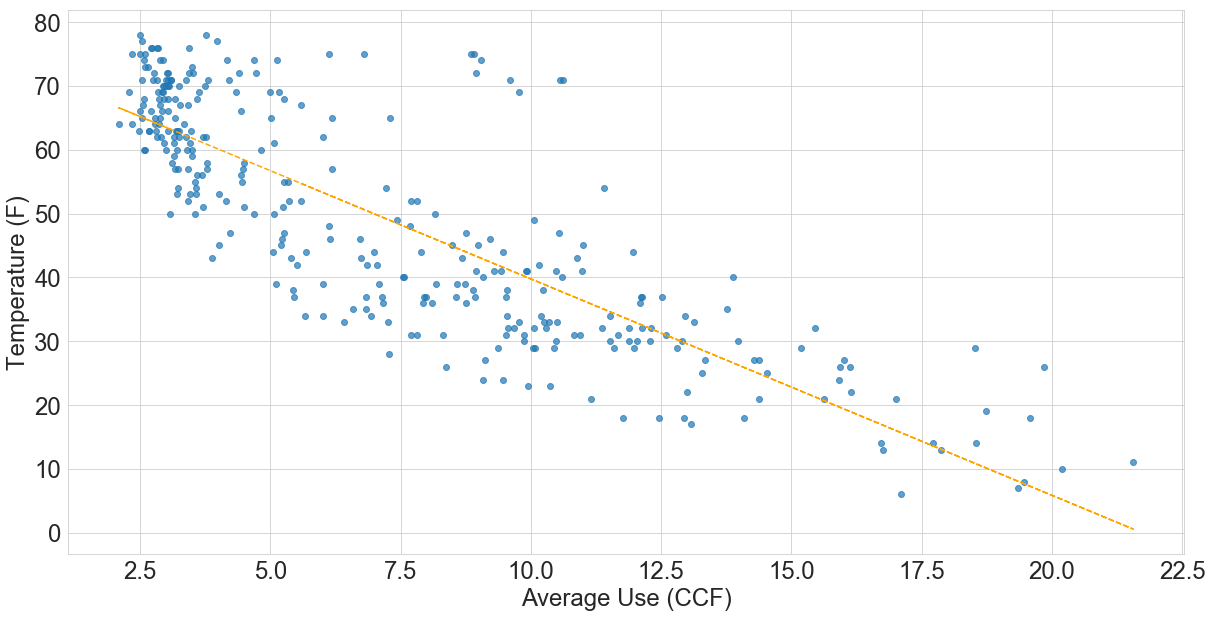

In [38]:
plt.rcParams.update({'font.size': 24})
f, ax = plt.subplots(figsize=(20, 10))
sns.set_style('whitegrid')

p = np.polyfit(data.Use, data.LowDB1, deg=1)
x = data.Use
y = p[1] + p[0] * data.Use

plt.plot(data.Use, data.LowDB1, 'o', alpha=.7)
plt.plot(x, y,'--', color='orange')
ax.set_xlabel("Average Use (CCF)"); ax.set_ylabel("Temperature (F)");
# use & lag-temperature are approx linear

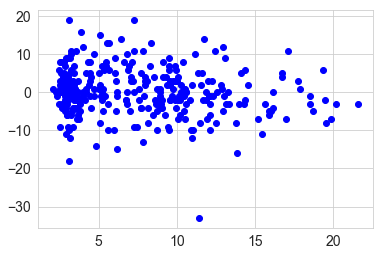

In [61]:
plt.plot(data.Use, data.LowDB1delta, 'bo')
# use & lag-delta-temp are approx linear